# Bridging the Divide: The Future of Gender Wage Equality
### A data story authored by Grace Sun and Louie Lu

In the ongoing quest for equality in the workplace, the gender pay gap remains a persistent and troubling reality. This detailed exploration uncovers disparities by gender across various dimensions of the employment landscape. From a broad examination of wage differences affecting all workers, our analysis narrows, delving into specific occupations and education levels. Though the quest for wage equality has made strides, the pace of change has been slow, marked by complex layers of systemic biases and cultural hurdles. By deploying data-driven insights and robust visualizations, this article paints a comprehensive picture of the gender pay gap. Each section brings us in closer, illustrating how these disparities differ across different groups of Americans. As we navigate through these findings, it becomes evident that the journey toward pay parity is ongoing and fraught with challenges. Yet, understanding the contours of this issue is a critical step toward forging paths to equality. Join us as we dissect the multifaceted phenomenon of wage inequality in the United States, revealing its pervasive impact and the collective effort required to eradicate it.

## How we did this
Our project analysis utilized the Annual Social and Economic Supplements (ASEC) from the United States Census Bureau as the primary data source, complemented by aggregated data from IPUMS-CPS. This resource offers an online tool for creating data extractions from the CPS and ASEC, featuring enhancements such as cleaned data, handling of corner cases, and aggregation of data across different years and variations of similar questions.

The scope of our data includes individuals aged 18 to 65 who are employed full-time by companies and report a weekly working time of at least 35 hours. We excluded self-employed individuals from our analysis due to the challenges associated with accurately measuring their hourly earnings. The dataset spans from 1976 to 2023.

Our method for calculating hourly earnings involves multiplying the reported weekly earnings by the number of working weeks in the previous year, then dividing by the average weekly working hours. To ensure consistency over time in terms of purchasing power, all earnings figures were adjusted to 2022 dollars using the Consumer Price Index (CPI99) and the IPUMS dollar conversion table.

## The gender pay gap is getting smaller over time

In [5]:
import pathlib

import pandas as pd
import seaborn as sns
import altair as alt
import numpy as np

In [6]:
BASE_DIR = pathlib.Path("")
FIGS_DIR = BASE_DIR / "figs"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

asec = pd.read_pickle(
    BASE_DIR / "asec.pkl.gz",
    compression="gzip"
)

# Filtering
#asec = asec[asec["WORKLY"] == 2] # worked last year
asec = asec[asec["FULLPART"] == 1] # fulltime
asec = asec[asec["UHRSWORKLY"] >= 35] # work at least 35 hours

# Adjust inflation to 2022 dollars
asec["INCWAGE_U"] = asec["INCWAGE"] * asec["CPI99"] * 1.797

# Calculate hourly wage based on adjusted wage
asec["HOURLYWAGE"] = asec["INCWAGE_U"] / (asec["WKSWORK1"] * asec["UHRSWORKLY"])

# Update gender label
asec["SEX"] = asec["SEX"].astype(str).replace({"1": "Male", "2": "Female"})

In [7]:
# Ref: https://blog.datawrapper.de/gendercolor/, Economist, 2018
gender_colors = ["#EE5A45", "#1E8F89"]

colors_ = ["#edf8b1", "#7fcdbb", "#2c7fb8"] # colorblind safe for seq data

In [8]:
# Gender median hourly wage
median_wages = asec.groupby(["YEAR", "SEX"])["HOURLYWAGE"].median().reset_index()
chart = alt.Chart(median_wages).mark_line(point=True).encode(
    x=alt.X("YEAR:O", title="Year"),
    y=alt.Y("HOURLYWAGE:Q", title="Median Hourly Earnings ($US)",
            scale=alt.Scale(domain=[0, 40])),
    color=alt.Color("SEX:N",
      scale=alt.Scale(domain=['Male', 'Female'], range=gender_colors))
).properties(width=600, title="Median Hourly Earnings by Year")

chart.save(FIGS_DIR / "by_dollar.png")
chart

alt.Chart(...)

Over time, the overall gender pay gap in hourly wages has gotten smaller, reflecting societal shifts in gender roles and efforts to move towards pay parity. While the median hourly earnings for men has stayed mostly constant from 1976 to 2023, women have seen a steady increase in hourly pay, from about \\$17 an hour in 1976 to almost \$25 an hour in 2023. However, the pay gap looks different across income classes, as we will discuss in the next section.

## The gender pay gap increases as income class increases

In [9]:
gender_wages = (
    asec.groupby(["YEAR", "SEX"])["HOURLYWAGE"]
    .apply(lambda x: x.quantile([0.15, 0.5, 0.9]))
    .unstack()
    .reset_index()
)
gender_wages.columns = ["YEAR", "SEX", "15th", "50th", "90th"]
wage_melted = gender_wages.melt(id_vars=['YEAR', 'SEX'], value_vars=['15th', '50th', '90th'],
                                    var_name='Percentile', value_name='HOURLYWAGE')


def create_percentile_chart(name, percentile_name, ymin=0, ymax=80):
    # Filter data for the specified percentile
    subset = wage_melted[wage_melted['Percentile'] == percentile_name]
    chart = alt.Chart(subset).mark_line(point=True).encode(
        x=alt.X('YEAR:O', axis=alt.Axis(values=list(range(1980, 2030, 10))), title='Year'),
        y=alt.Y('HOURLYWAGE:Q', scale=alt.Scale(domain=[ymin, ymax]), title='Hourly Earnings (US$, Adjusted to 2022)'),
        color=alt.Color('SEX:N', legend=alt.Legend(title="Sex"),
                        scale=alt.Scale(domain=['Male', 'Female'], range=gender_colors)),  # Custom colors
        shape=alt.Shape('SEX:N', legend=alt.Legend(title="Sex"),
                        scale=alt.Scale(domain=['Male', 'Female'], range=['square', 'triangle-up'])),  # Custom shapes
        tooltip=['YEAR', 'SEX', 'HOURLYWAGE']
    ).properties(
        width=400,
        title=f'{name} Hourly Earnings by Gender Over Time'
    )
    return chart

chart = create_percentile_chart("Lower Income", "15th", 0, 75) | create_percentile_chart("Middle Income", "50th", 0, 75) | create_percentile_chart("Higher Income", "90th", 0, 75)
chart

alt.HConcatChart(...)

According to [Pew Research](https://www.pewresearch.org/short-reads/2020/07/23/are-you-in-the-american-middle-class), 29% of American adults fall into the low income bracket, 52% into the middle income, and 19% into the upper income category. These visualizations illustrate the median hourly earnings (at the 15th, 50th, and 90th percentiles) for each income class, shedding light on the disparities between men and women's wages within these segments. A striking aspect of these charts is the escalating disparity in pay as one moves up the income scale. The lower income bracket displays the smallest gap, with instances where women have out-earned men, suggesting a more level playing field historically at this income level. In stark contrast, the higher income bracket shows a persistent and considerable gap, with men earning $15 to $20 more per hour than their female counterparts—a gap that has not narrowed significantly over time. The highest earners illustrate the most pronounced inequality, potentially reflecting entrenched systemic biases that disproportionately affect women in top-earning positions. There has been a gradual narrowing of the wage gap in middle and higher income categories over the years, reflecting efforts to reach pay parity.

# Men earn higher salaries at a higher rate than women

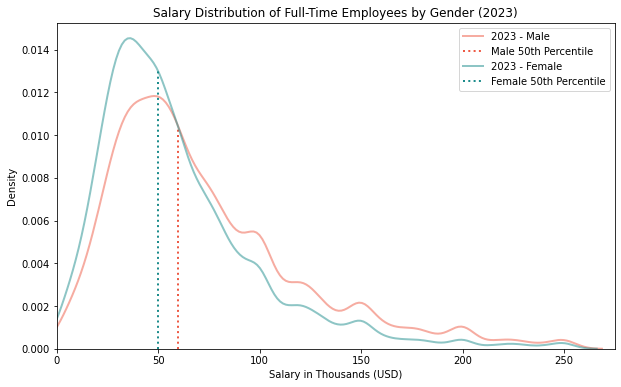

In [29]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the data file 'asec_2023.pkl' is in the directory 'data'
data_file = "asec_2023.pkl"

# Load the data for 2023
asec = pickle.load(open(data_file, "rb"))

# Assuming the structure contains these keys, and 'a_wkstat' indicates working status with 2 for full-time
full_time = asec[asec["a_wkstat"] == 2]
mean = full_time["wsal_val"].mean()
std = full_time["wsal_val"].std()

# Define the bounds for salary data to be considered
lower_bound = 1
upper_bound = mean + 2 * std

# Filter the data for valid salary ranges
filtered_data = full_time[(full_time["wsal_val"] >= lower_bound) & (full_time["wsal_val"] <= upper_bound)]

# Separate the data by gender
male = filtered_data[filtered_data["a_sex"] == 1]
female = filtered_data[filtered_data["a_sex"] == 2]

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# KDE plot for males
sns.kdeplot(
    male["wsal_val"]/1000,
    ax=ax,
    alpha=0.5,
    label="2023 - Male",
    color="#ee5a45",
    linewidth=2
)
# Male median salary
male_median = male["wsal_val"].median() / 1000
ax.vlines(male_median, 0, 0.0103, color='#ee5a45', linestyle=':', linewidth=2, label='Male 50th Percentile')

# KDE plot for females
sns.kdeplot(
    female["wsal_val"]/1000,
    ax=ax,
    alpha=0.5,
    label="2023 - Female",
    color="#1c8c8c",
    linewidth=2
)
# Female median salary
female_median = female["wsal_val"].median() / 1000
ax.vlines(female_median, 0, 0.013, color='#1c8c8c', linestyle=':', linewidth=2, label='Female 50th Percentile')

# Finishing touches on the plot
ax.set_title("Salary Distribution of Full-Time Employees by Gender (2023)")
ax.set_xlabel("Salary in Thousands (USD)")
ax.set_ylabel("Density")
ax.set_xlim(0, 275)
ax.legend()

plt.show()

A clear discrepancy exists between full time male and female employee income in the United States. The salary curve for males peaks at a higher salary point and exhibits a broader range, suggesting not only that men, on average, tend to earn more, but also that there is a greater diversity in their salaries. Conversely, the curve for females peaks at a lower salary point and is narrower, indicating a concentration of female earnings in a more confined income range. The median income of men is clearly higher than the median income for women in full time positions.This pattern highlights a persistent gender wage gap, where the density of higher salaries diminishes more rapidly for women than for men, pointing towards systemic disparities in the workplace.

# The gender pay gap is smaller for advanced degree holders

In [10]:
edu_wages = (
    asec.groupby(["YEAR", "SEX", "EDUC"])["HOURLYWAGE"]
    .apply(lambda x: x.quantile([0.15, 0.5, 0.9]))
    .unstack()
    .reset_index()
)
edu_wages['EDUC'] = edu_wages['EDUC'].astype(int)

# Conditions
conditions = [
    edu_wages['EDUC'] <= 71,                           # Less than high school graduate
    (edu_wages['EDUC'] > 71) & (edu_wages['EDUC'] <= 73) ,       # High school graduate
    (edu_wages['EDUC'] > 73) & (edu_wages['EDUC'] <= 92),       # Some college
    (edu_wages['EDUC'] > 99) & (edu_wages['EDUC'] <= 122),                          # Bachelor
    (edu_wages['EDUC'].isin([123, 124])),                # Master
    edu_wages['EDUC'] == 125                           # Doctorate
]

# Choices corresponding to each condition
choices = [
    '1. Less than high school graduate',
    '2. High school graduate',
    '3. Some college',
    '4. Bachelor',
    '5. Master',
    '6. Doctorate'
]

# Apply the conditions and choices to the DataFrame
edu_wages['EDUC_recode'] = np.select(conditions, choices, default='other')
edu_wages = edu_wages[edu_wages["EDUC_recode"] != "other"]

In [11]:
df_percent = edu_wages.pivot_table(index=['YEAR', 'EDUC_recode'], columns='SEX', values=0.5).reset_index()
df_percent['Female_as_percentage_of_Male'] = df_percent['Female'] / df_percent['Male'] * 100

# Filter out the years of interest (e.g., 1982, 2002, 2022)
years_of_interest = [1976, 1992, 2023]
df_final = df_percent[df_percent['YEAR'].isin(years_of_interest)]

# Now we create the chart
base = alt.Chart(df_final).encode(
    alt.Y('EDUC_recode:O', title='Education Level'),
)

# Dot plot for each year
dots = base.mark_circle(size=128, stroke="black", strokeWidth=1).encode(
    alt.X('Female_as_percentage_of_Male:Q',
          title='Median Hourly Earnings of Women as a % of Men')
    .axis(None),
    alt.Color('YEAR:N', legend=alt.Legend(title="Year")),
    alt.Tooltip(['EDUC_recode', 'YEAR', 'Female_as_percentage_of_Male']),
    opacity=alt.value(1)
)

texts = base.mark_text(dy=15).encode(
    alt.X('Female_as_percentage_of_Male:Q'),
    text=alt.Text("Female_as_percentage_of_Male:Q",
                  format=",.0f")
)

# Rule plot to draw lines across the dots for each education level
rules = base.mark_rule().encode(
    alt.X('a:Q', scale=alt.Scale(domain=[49, 101]),
          axis=alt.Axis(title="Percentage")),
    alt.X2("b:Q")
).transform_calculate(
    a="50",
    b="100",
)


# Combine the plots
chart = (rules + dots + texts).properties(
    width=500, height=300,
    title=["Median Hourly Earnings of Women in the U.S. as a % of Men Median Hourly Earnings",
           "By Education Level"])
chart = chart.configure_axis(grid=False).configure_view(stroke=None).configure_range(category=alt.RangeScheme(colors_))
chart.save(FIGS_DIR / "by_education.png")
chart

alt.LayerChart(...)

Across varying education levels, from less than a high school diploma to a bachelor's degree, the gender pay gap remains relatively uniform. However, the gap diminishes notably among those with advanced degrees; it is less pronounced for holders of master's degrees and even more so for those with doctorates, where women earn just 10% less than men. This is a marked improvement compared to the approximately 20% less that women with a bachelor's degree or lower education earn compared to men, and the 15% disparity for those with a master's degree. Ideally, the disparity should be non-existent, yet there's an observable trend of gradual reduction over time. Interestingly, while the pay gap for individuals with bachelor's and master's degrees has widened slightly from 1992 to 2023, all other educational levels have seen a steady advance toward closing the gender pay gap.

# Men make more money across occupations, but the pay gap has steadily decreased in most occupations over time

In [12]:
ind_wages = (
    asec.groupby(["YEAR", "SEX", "IND50LY"])["HOURLYWAGE"]
    .apply(lambda x: x.quantile([0.15, 0.5, 0.9]))
    .unstack()
    .reset_index()
)
ind_wages['IND50LY'] = ind_wages['IND50LY'].astype(int)

In [13]:
def recode_ind(df):
    # Define conditions
    conditions = [
        df['IND50LY'].between(105, 126),  # Agriculture, Forestry, and Fishing
        df['IND50LY'].between(206, 239),  # Mining
        df['IND50LY'] == 246,             # Construction
        df['IND50LY'].between(306, 499),  # Manufacturing
        df['IND50LY'].between(506, 599),  # Transportation, Communication, Utilities
        df['IND50LY'].between(606, 699),  # Wholesale and Retail Trade
        df['IND50LY'].between(716, 749),  # Finance, Insurance, and Real Estate
        df['IND50LY'].between(806, 849),  # Business and Repair Services
        df['IND50LY'].between(856, 859),  # Entertainment and Recreation Services
        df['IND50LY'].between(868, 899),  # Professional and Related Services
        df['IND50LY'].between(906, 936),  # Public Administration
        df['IND50LY'].isin([997, 998])    # Others and Not reported
    ]

    # Define choices
    choices = [
        '02. Agriculture, Forestry, and Fishing',
        '03. Mining',
        '01. Construction',
        '04. Manufacturing',
        '05. Transportation, Communication, and Utilities',
        '06. Wholesale and Retail Trade',
        '07. Finance, Insurance, and Real Estate',
        '08. Business and Repair Services',
        '09. Entertainment and Recreation Services',
        '10. Professional and Related Services',
        '11. Public Administration',
        '12. Others or Not Reported'
    ]

    df['IND50LY_U'] = np.select(conditions, choices, default='Unknown')

recode_ind(ind_wages)
ind_wages = ind_wages[ind_wages["IND50LY_U"] != "Unknown"]

In [14]:
def recode_ind_gender_year(df):
    # Define conditions
    conditions = [
        df['IND50LY'].between(105, 126),  # Agriculture, Forestry, and Fishing
        df['IND50LY'].between(206, 239),  # Mining
        df['IND50LY'] == 246,             # Construction
        df['IND50LY'].between(306, 499),  # Manufacturing
        df['IND50LY'].between(506, 599),  # Transportation, Communication, Utilities
        df['IND50LY'].between(606, 699),  # Wholesale and Retail Trade
        df['IND50LY'].between(716, 749),  # Finance, Insurance, and Real Estate
        df['IND50LY'].between(806, 849),  # Business and Repair Services
        df['IND50LY'].between(856, 859),  # Entertainment and Recreation Services
        df['IND50LY'].between(868, 899),  # Professional and Related Services
        df['IND50LY'].between(906, 936),  # Public Administration
        df['IND50LY'].isin([997, 998])    # Others and Not reported
    ]

    # Define choices
    choices = [
        '02. Agriculture, Forestry, and Fishing',
        '03. Mining',
        '01. Construction',
        '04. Manufacturing',
        '05. Transportation, Communication, and Utilities',
        '06. Wholesale and Retail Trade',
        '07. Finance, Insurance, and Real Estate',
        '08. Business and Repair Services',
        '09. Entertainment and Recreation Services',
        '10. Professional and Related Services',
        '11. Public Administration',
        '12. Others or Not Reported'
    ]

    df['IND50LY_U'] = np.select(conditions, choices, default='Unknown')

ind_gender_year = asec.copy()
ind_gender_year['IND50LY'] = ind_gender_year['IND50LY'].astype(int)
recode_ind_gender_year(ind_gender_year)
ind_gender_year = ind_gender_year[ind_gender_year["IND50LY_U"] != "Unknown"]
ind_gender_year = ind_gender_year.groupby(['YEAR', 'SEX', "IND50LY_U"]).size().unstack(fill_value=0)

ind_gender_year = ind_gender_year.unstack("SEX")

for ind, _ in ind_gender_year:
    ind_gender_year[ind, "Gender Ratio"] = ind_gender_year[ind, "Male"] / ind_gender_year[ind, "Female"]
    ind_gender_year[ind, "Gender Total"] = ind_gender_year[ind, "Male"] + ind_gender_year[ind, "Female"]

    ind_gender_year[ind, "Male Share"] = ind_gender_year[ind, "Male"] / ind_gender_year[ind, "Gender Total"] * 100
    ind_gender_year[ind, "Female Share"] = ind_gender_year[ind, "Female"] / ind_gender_year[ind, "Gender Total"] * 100

ind_gender_year = ind_gender_year.unstack(level="YEAR")
ind_gender_year = ind_gender_year.unstack(level="SEX").reset_index()

In [18]:
def format_float(x, other_col):
    if other_col == '01. Construction':
        return '{:.0f}%'.format(x)
    else:
        return '{:.0f}'.format(x)



df_percent = ind_wages.pivot_table(index=['YEAR', 'IND50LY_U'], columns='SEX', values=0.5).reset_index()
df_percent['Female_as_percentage_of_Male'] = df_percent['Female'] / df_percent['Male'] * 100
df_percent['Female_as_percentage_of_Male_U'] = df_percent.apply(
    lambda row: format_float(row['Female_as_percentage_of_Male'], row['IND50LY_U']), axis=1)
df_percent = df_percent[~((df_percent['YEAR'] == 2023) & 
                          (df_percent['IND50LY_U'] == "03. Mining") & 
                          (df_percent['Female_as_percentage_of_Male'] > 400))]

# Filter out the years of interest (e.g., 1982, 2002, 2022)
years_of_interest = [1976, 1992, 2023]
df_final = df_percent[df_percent['YEAR'].isin(years_of_interest)]

# Now we create the chart
base = alt.Chart(df_final).encode(
    alt.Y('IND50LY_U:O', title='Industry'),
)

# Dot plot for each year
dots = base.mark_circle(size=128, stroke="black", strokeWidth=1).encode(
    alt.X('Female_as_percentage_of_Male:Q',
          title='Median Hourly Earnings of Women as a % of Men')
    .axis(None),
    alt.Color('YEAR:N', legend=alt.Legend(title="Year")),
    alt.Tooltip(['IND50LY_U', 'YEAR', 'Female_as_percentage_of_Male']),
    opacity=alt.value(1),
)

texts = base.mark_text(dy=15, align="center").encode(
    alt.X('Female_as_percentage_of_Male:Q'),
    text=alt.Text("Female_as_percentage_of_Male_U:O")
).transform_calculate(label='"inches"')

# Rule plot to draw lines across the dots for each education level
rules = base.mark_rule().encode(
    alt.X('a:Q', scale=alt.Scale(domain=[49, 131]),
          axis=alt.Axis(title="Percentage")),
    alt.X2("b:Q")
).transform_calculate(
    a="50",
    b="130",
)

row_of_interest = df_final[df_final['IND50LY_U'] == "01. Construction"]
annotation = alt.Chart(row_of_interest).mark_text(dy=-15, align="center").encode(
    alt.X('Female_as_percentage_of_Male:Q'),
    alt.Y('IND50LY_U:O'),
    text=alt.Text('YEAR:N'),  # Display the value of IND50LY_U as text
)
# Lines from text to points
lines = annotation.mark_rule().encode(
    x='Female_as_percentage_of_Male:O',
    y='IND50LY_U:O',
    y2=alt.value(0)  # Adjust if needed to control where the line ends
)


# Combine the plots
chart = (rules + dots + texts + annotation).properties(
    width=600, height=400,
    title=["Median Hourly Earnings of Women in the U.S. as a % of Men Median Hourly Earnings",
           "By Industry"])
chart = chart.configure_axis(grid=False).configure_view(stroke=None).configure_range(category=alt.RangeScheme(colors_))
chart.save(FIGS_DIR / "by_industry.png")
chart


alt.LayerChart(...)

The graph above tracks the gender wage gap across various industries over nearly five decades, highlighting a trend towards narrowing this gap in most sectors since 1976. However, there's an exception in professional and related services, where the gap has slightly increased. A remarkable shift occurred in the entertainment and recreation services industry around 1992, showing a significant closure of the gap, but by 2023, it regressed, broadening once more. Intriguingly, in 1992, the agriculture, forestry, and fishing sector saw a unique reversal, with women earning 29% more than men, an anomaly that was short-lived as by 2023, the gap not only closed but reversed, with women earning 10% less than men—a setback to even the figures of 1976. Despite these fluctuations, the overall trajectory in most industries points towards diminishing wage disparities, fostering optimism for an eventual eradication of the gender pay gap.

To further analyze the trends behind the pay gap changes over time across these industries, feel free to click through this interactive visualization that allows for a focus on the income trends over time in specific industries:

In [34]:
dropdown = alt.binding_select(options=df_percent["IND50LY_U"].unique(), name="Select a industry: ")
selection = alt.selection_point(
    fields=["IND50LY_U"], bind=dropdown,
    value="02. Agriculture, Forestry, and Fishing"
)

base = alt.Chart(df_percent).properties(width=600, height=300)
lines = base.mark_line(point=True).encode(
    x=alt.X("YEAR:O", title="Year"),
    y=alt.Y("Female_as_percentage_of_Male:Q", scale=alt.Scale(domain=[0, 200]),
            axis=alt.Axis(title="Median Hourly Earning Female as % of Male", titleColor="#5276a7")),
    tooltip=["YEAR", "Female_as_percentage_of_Male"]
).transform_filter(selection).add_params(selection)

male_lines = alt.Chart(ind_gender_year).mark_line(stroke=gender_colors[0]).encode(
    x=alt.X("YEAR:O"),
    y=alt.Y("Male Share:Q",
            scale=alt.Scale(domain=[0, 100]),
            axis=alt.Axis(title="Male Share (%)", titleColor=gender_colors[0])),
).transform_filter(selection).add_params(selection)

female_lines = alt.Chart(ind_gender_year).mark_line(stroke=gender_colors[1]).encode(
    x=alt.X("YEAR:O"),
    y=alt.Y("Female Share:Q",
            scale=alt.Scale(domain=[0, 100]),
            axis=alt.Axis(title="Female Share (%)", titleColor=gender_colors[1], offset=50)),
).transform_filter(selection).add_params(selection)

title = base.mark_text(dy=-170, size=20).encode(
    text="IND50LY_U:N"
).transform_filter(selection)

chart = alt.layer(lines + title, male_lines, female_lines).resolve_scale(
    y = 'independent'
).properties(title="Median Hourly Earning, Male & Female Share")

#chart.save("new_figs/by_industry_with_gender_share.png")
#chart.save("new_figs/test.html")
chart

alt.LayerChart(...)

## What's next for the gender pay gap?

As the nation strides toward equal pay, the gender pay gap, though narrowing, continues to present a complex challenge. Our thorough examination across occupations and educational levels highlights a slow yet positive trend towards smaller disparities in wages. The most encouraging signs of progress are seen at higher levels of education, where the gap is smallest. However, the overarching narrative is that significant work remains to achieve true parity. The fact that the pay gap persists across all sectors and widens with income underscores the need for sustained and strategic efforts to dismantle the systemic barriers that underpin wage inequality. The future of the gender pay gap depends on a collective push for equitable policies, enhanced educational opportunities, and a cultural shift that redefines the value of work irrespective of gender. It's a multipronged battle against time-worn biases, one that requires the vigilance of policymakers, the commitment of industries, and the awareness of society at large.